In [2]:
from transformers import AutoTokenizer, AutoModel, BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from bert_utils import BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
import os
from modeling.modeling_utils import *
from transformers.optimization import get_linear_schedule_with_warmup, AdamW, get_cosine_schedule_with_warmup
import json
import torch

import logging
import json
import matplotlib.pyplot as plt
from csv import DictWriter

in the modeling class


In [3]:
cd ..

/home/x1112373/clinicalBERT/CS598-project


In [4]:
best_model_path = './experiment/readmission_model_experiment/readmission_clinical_bert_BATCH_SIZE_16_LEARNING_RATE_2e-05_gradient_accu_2_MAX_GRAD_NORM_1_0.pt'
Classifier = BertForSequenceClassification.from_pretrained('./pretraining', 1)
Classifier.load_state_dict(torch.load(best_model_path))

05/08/2022 22:52:41 - INFO - bert_utils -   loading archive file ./pretraining
05/08/2022 22:52:41 - INFO - bert_utils -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



<All keys matched successfully>

In [5]:
def transpose_for_scores(config, x):
    new_x_shape = x.size()[:-1] + (config.num_attention_heads, int(config.hidden_size / config.num_attention_heads))
    x = x.view(*new_x_shape)
    return x.permute(0, 2, 1, 3)

In [6]:
def get_attention_scores(model,i,text):
    tokenized=tokenizer.tokenize(text)

    indexed_tokens=tokenizer.convert_tokens_to_ids(tokenized)

    segment_ids=[0]*len(indexed_tokens)
    t_tensor=torch.tensor([indexed_tokens])
    s_ids=torch.tensor([segment_ids])

    outputs_query= []
    outputs_key= []

    def hook_query(module, input, output):
        #print ('in query')
        outputs_query.append(output)

    def hook_key(module, input, output):
        #print ('in key')
        outputs_key.append(output)

    model.bert.encoder.layer[i].attention.self.query.register_forward_hook(hook_query)
    model.bert.encoder.layer[i].attention.self.key.register_forward_hook(hook_key)
    l=model(t_tensor,s_ids)
    
    query_layer = transpose_for_scores(bert_config,outputs_query[0])
    key_layer = transpose_for_scores(bert_config,outputs_key[0])
    
    attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
    attention_scores = attention_scores / math.sqrt(int(bert_config.hidden_size / bert_config.num_attention_heads))
    attention_probs = nn.Softmax(dim=-1)(attention_scores)
    
    return attention_probs,tokenized

In [7]:
need_proxy = True
if need_proxy:
    local_test = False
    proxy_file_path = f"./secrets.json"

if local_test:
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
else:
    with open(proxy_file_path, "r") as json_file:
        json_data = json.load(json_file)
        proxies = json_data['proxies']
        tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', proxies=proxies) 


In [8]:
cd modeling

/home/x1112373/clinicalBERT/CS598-project/modeling


In [9]:
pwd

'/home/x1112373/clinicalBERT/CS598-project/modeling'

In [10]:
from bert_utils import BertConfig
import math
bert_config = BertConfig.from_json_file('../pretraining/bert_config.json')
#model = BertForSequenceClassification(bert_config, 1)

In [11]:
text=' he has experienced acute on chronic diastolic heart failure in the setting of volume overload due to his sepsis.'
x, tokens=get_attention_scores(Classifier,0,text)

In [12]:
map1=np.asarray(x[0][1].detach().numpy())

len(tokens)

24

In [13]:
import seaborn as sns
f, ax = plt.subplots(figsize=(6,8))
sns.heatmap(map1, annot=False, fmt="f", ax=ax, xticklabels = False, yticklabels = False, vmax=0.4, cmap='Reds', cbar_kws={'label':'Attention Weight', 'orientation':'horizontal'}, rasterized = True)

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

<Figure size 432x288 with 0 Axes>

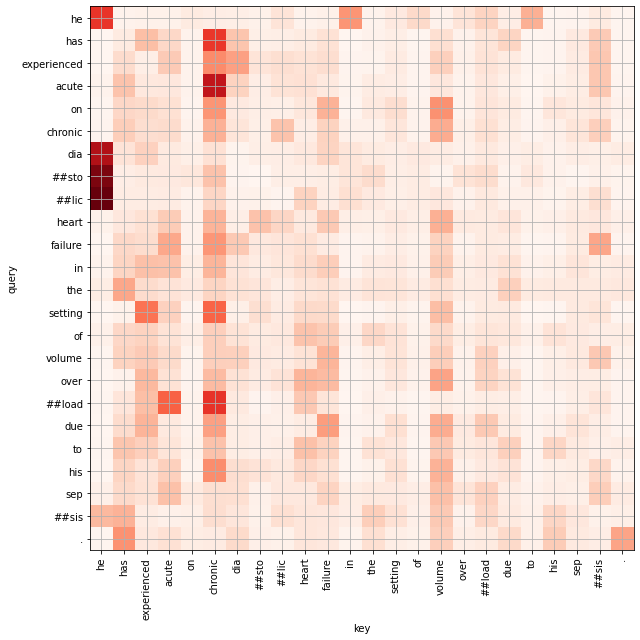

In [15]:
plt.clf()

f=plt.figure(figsize=(10,10))
ax = f.add_subplot(1,1,1)
i=ax.imshow(map1,interpolation='nearest',cmap='Reds')

ax.set_yticks(range(len(tokens)))
ax.set_yticklabels(tokens)

ax.set_xticks(range(len(tokens)))
ax.set_xticklabels(tokens, rotation=90)

ax.set_xlabel('key')
ax.set_ylabel('query')

ax.grid(linewidth = 0.8)